In [1]:
import numpy as np
import paint_auth as pa
import pandas as pd
import tensorflow as tf
import resnet
import glob
from lxml import etree as ET
from collections import Counter
from sklearn.model_selection import train_test_split

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
def shuffle(X, y):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [3]:
#import all xml and convert to pd dataframe
#only extract painters
path = '/Users/Mason/Desktop/adv_big_data/data/xml2'
file_names = glob.glob(path+'/**')

#initialize dict and parser
info = {}
parser = ET.XMLParser(recover=True)
for i in range(len(file_names)):
    im_name = file_names[i].split('/')[-1]
    tree = ET.parse(file_names[i], parser)
    title, artist, medium, period = pa.extract_info(tree.getroot())
    if medium == 'schilderij' or medium == 'tekening': #painting or drawing in Dutch...
        if artist is not None:
            artist = artist.split(': ')[-1]
        im_name = im_name.split('.xml')[0]
        info[i] = (im_name, title, artist, medium, period)

info = pd.DataFrame.from_dict(info, 'index').rename(index=str, columns={0:'file_name', 1:'title', 2:'artist', 3:'medium', 4:'period'})

In [4]:
#counting and sorting artists' number of paintings
counts = Counter(info['artist'].tolist())
counts = pd.DataFrame.from_dict(counts, orient='index').sort_values(by=0,ascending=False)
#getting subset of artists with decent number of paintings
my_artists = counts.index[1:6].tolist()
my_artists = info[info['artist'].isin(my_artists)]

In [5]:
image_path = '/Users/Mason/Desktop/adv_big_data/data/jpg2'
paintings, mult, one_hot = pa.import_dataset(image_path, my_artists)

imported images: 100
imported images: 200
imported images: 300
imported images: 400
imported images: 500
imported images: 600
imported images: 700
imported images: 800
imported images: 900
imported images: 1000
imported images: 1100
imported images: 1200
imported images: 1300
imported images: 1400


In [6]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(paintings, one_hot, test_size=0.2, stratify=one_hot)

In [7]:
#normalize training
import cv2
t = cv2.normalize(X_train[0].astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)
X_train = np.array([cv2.normalize(image.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX) for image in X_train])

In [8]:
#initializing Resnet
#hyperparams
alpha = 1e-2
BATCH_SIZE = 200
epochs = 25
n_classes = len(y_train[0])
shape = (256,256,3)
optimizer = tf.train.AdamOptimizer(alpha)
sess = tf.Session()
model = resnet.Resnet(shape, n_classes, optimizer, sess)
model.build_model()
model.build_loss()

(?, 5)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
#test run
sess.run(tf.global_variables_initializer())
model.predict([X_train[0]])

array([[0.19132851, 0.18727882, 0.19008645, 0.21685773, 0.21444847]],
      dtype=float32)

In [ ]:
train_acc = []
val_acc = []
#training
for ep in range(epochs):
    count = 0
    print 'starting epoch: %d' % ep
    X_train, y_train = shuffle(X_train, y_train)
    #train, val split
    
    X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
    for offset in range(0, len(y_train), BATCH_SIZE):
        print 'beginning training for iteration: %d' % count
        batch_X = X_t[offset: offset + BATCH_SIZE]
        batch_y = y_t[offset: offset + BATCH_SIZE]

        model.train(batch_X, batch_y)
        count += 1
    train_p = model.predict(X_t)
    val_p = model.predict(X_val)
    
    #retrieving labels
    train_p_labels = np.argmax(train_p)
    val_p_labels = np.argmax(val_p)
    labels = np.argmax(batch_y, 1)

    t_acc = np.mean((labels-train_p_labels)==0)
    v_acc = np.mean((labels-val_p_labels)==0)
    print 'train acc.: %f' % t_acc
    print 'validation acc.: %f' % v_cc
    train_acc.append(t_acc)
    val_acc.append(v_acc)
    _ = range(len(t_acc))
    plt.plot(_, t_acc, 'b')
    plt.plot(_, v_acc, 'g')
    plt.show()
    

starting epoch: 0
beginning training for iteration: 0


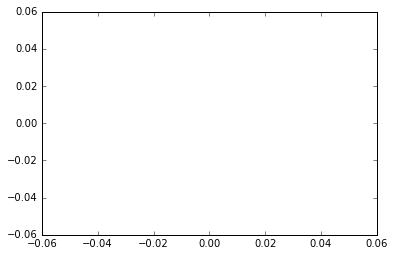

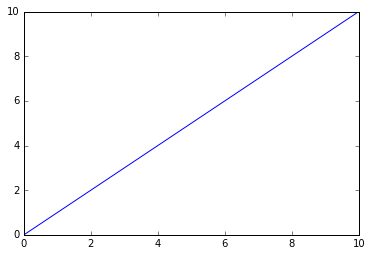

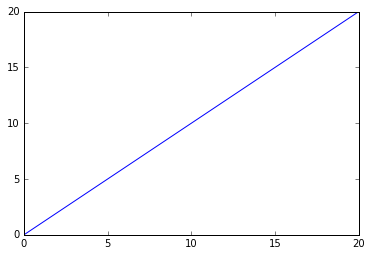

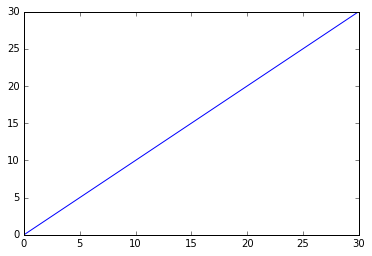

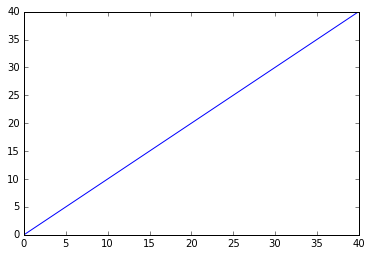

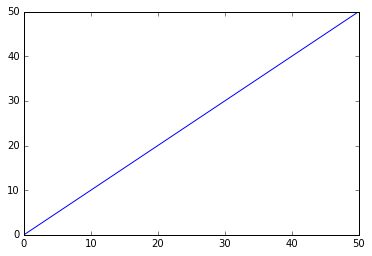

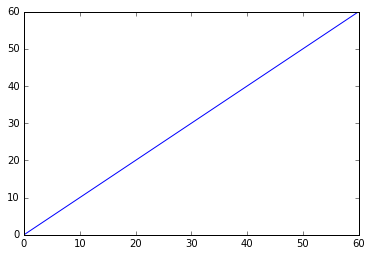

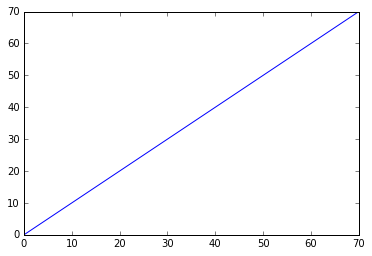

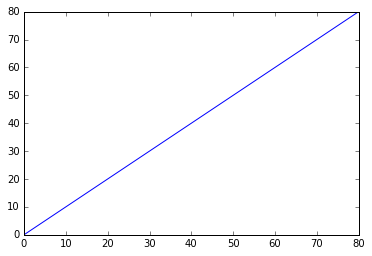

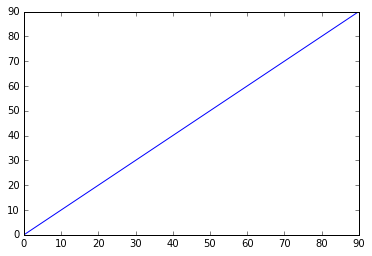

In [41]:
import matplotlib.pyplot as plt
test = []
f = plt.figure()
for i in range(100):
    test.append(i)
    if i % 10 == 0:
        plt.plot(test)
        plt.show()
        